# Fluxo de Kovasznay Inverso - Re=1000
---

In [20]:
import os
import re
os.environ['DDE_BACKEND'] = 'paddle'
import deepxde as dde
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# https://deepxde.readthedocs.io/en/latest/modules/deepxde.optimizers.html#module-deepxde.optimizers.config
dde.config.set_default_float("float64")
dde.optimizers.config.set_LBFGS_options(maxiter=30000)

dde.config.set_random_seed(42)
np.random.seed(42)

Set the default float type to float64


## Problema inverso

Aumentando o número de Reynolds (Re), o fluxo passa a ser turbulento, tornando o problema mais difícil de se resolver.

In [21]:
Re = 1000

Re_guess = 10.0

ex_Re = dde.Variable(Re_guess)

## Residual

Definimos as equações de Navier-Stokes como um residual a ser minimizado.

In [22]:
def pde(x, y):
    
    u, v, p = y[:, 0:1], y[:, 1:2], y[:, 2:]
    
    du_dx = dde.grad.jacobian(y, x, i=0, j=0)
    du_dy = dde.grad.jacobian(y, x, i=0, j=1)
    
    dv_dx = dde.grad.jacobian(y, x, i=1, j=0)
    dv_dy = dde.grad.jacobian(y, x, i=1, j=1)
    
    du_dxx = dde.grad.hessian(y, x, i=0, j=0, component=0)
    du_dyy = dde.grad.hessian(y, x, i=1, j=1, component=0)
    
    dv_dxx = dde.grad.hessian(y, x, i=0, j=0, component=1)
    dv_dyy = dde.grad.hessian(y, x, i=1, j=1, component=1)

    dp_dx = dde.grad.jacobian(y, x, i=2, j=0)
    dp_dy = dde.grad.jacobian(y, x, i=2, j=1)

    momentum_x = (
        u * du_dx + v * du_dy + dp_dx - 1 / ex_Re * (du_dxx + du_dyy)
    )
    
    momentum_y = (
        u * dv_dx + v * dv_dy + dp_dy - 1 / ex_Re * (dv_dxx + dv_dyy)
    )
    
    continuity = du_dx + dv_dy

    return [momentum_x, momentum_y, continuity]

## Solução Exata

$$
\lambda = \frac{1}{2v} - \sqrt{\frac{1}{4v^{2}} + 4\pi^{2}}
$$

$$
u = 1 - e^{\lambda x} cos(2\pi y), \quad 
v = \frac{\lambda}{2\pi}e^{\lambda x}sin(2\pi x), \quad
p = \frac{1}{2}(1 - e^{2\lambda x})
$$

In [23]:
nu = 1 / Re
l = 1 / (2 * nu) - np.sqrt(1 / (4 * nu ** 2) + 4 * np.pi ** 2)

In [24]:
def u_sol(x):
    return 1 - np.exp(l * x[:, 0:1]) * np.cos(2 * np.pi * x[:, 1:2])

def v_sol(x):
    return l / (2 * np.pi) * np.exp(l * x[:, 0:1]) * np.sin(2 * np.pi * x[:, 1:2])

def p_sol(x):
    return 1 / 2 * (1 - np.exp(2 * l * x[:, 0:1]))

## Condições de fronteira e dados

In [25]:
def boundary_outflow(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1)

spatial_domain = dde.geometry.Rectangle(xmin=[-0.5, -0.5], xmax=[1, 1.5])

u_bc = dde.icbc.DirichletBC(
    spatial_domain, u_sol, lambda _, on_boundary: on_boundary, component=0
)

v_bc = dde.icbc.DirichletBC(
    spatial_domain, v_sol, lambda _, on_boundary: on_boundary, component=1
)

right_p_bc = dde.icbc.DirichletBC(
    spatial_domain, p_sol, boundary_outflow, component=2
)

data_cp = spatial_domain.random_points(1000)

data_u = u_sol(data_cp)
data_v = v_sol(data_cp)
data_p = p_sol(data_cp)

data_u_bc = dde.icbc.PointSetBC(data_cp, data_u, component=0)
data_v_bc = dde.icbc.PointSetBC(data_cp, data_v, component=1)
data_p_bc = dde.icbc.PointSetBC(data_cp, data_p, component=2)

## Pontos de colocação

In [26]:
num_domain = 2048
num_boundary = 400
num_test = 512

In [27]:

data = dde.data.PDE(
    spatial_domain,
    pde,
    [
        u_bc, v_bc, right_p_bc,
        data_u_bc, data_v_bc, data_p_bc
    ],
    num_domain=num_domain,
    num_boundary=num_boundary,
    num_test=num_test,
    anchors=data_cp
)

## Definindo as configurações da rede

In [28]:
n_hidden_layers = 4
nodes_per_layer = 50
topology = [2] + n_hidden_layers * [nodes_per_layer] + [3]
activation = "tanh"
initialization = "Glorot normal"

net = dde.nn.FNN(topology, activation, initialization)

model = dde.Model(data, net)

## Treinando o modelo

In [29]:
ex_variable_cb = dde.callbacks.VariableValue(
    [ex_Re], 
    period=1000, 
    filename=f"./parameters/reynolds-{Re}.dat"
)

model.compile("adam", lr=1e-3, external_trainable_variables=[ex_Re])
losshistory, train_state = model.train(
    iterations=30000, 
    display_every=5000,
    callbacks=[ex_variable_cb])

model.compile("L-BFGS", external_trainable_variables=[ex_Re])
losshistory, train_state = model.train(
    iterations=30000,
    display_every=5000, 
    callbacks=[ex_variable_cb])

Compiling model...
'compile' took 0.000247 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [1.40e-02, 5.64e-02, 2.35e-01, 3.09e+00, 8.21e-02, 1.10e-02, 1.92e+00, 4.73e-02, 1.65e-02]    [1.26e-02, 5.74e-02, 2.40e-01, 3.09e+00, 8.21e-02, 1.10e-02, 1.92e+00, 4.73e-02, 1.65e-02]    []  
5000      [4.67e-02, 3.52e-03, 4.88e-03, 5.38e-02, 1.47e-03, 8.47e-03, 1.12e-01, 3.61e-03, 2.76e-02]    [5.34e-02, 2.23e-03, 5.20e-03, 5.38e-02, 1.47e-03, 8.47e-03, 1.12e-01, 3.61e-03, 2.76e-02]    []  
10000     [3.91e-02, 1.41e-03, 3.60e-03, 2.65e-02, 3.73e-03, 1.42e-02, 7.06e-02, 2.65e-03, 2.38e-02]    [4.80e-02, 1.22e-03, 3.54e-03, 2.65e-02, 3.73e-03, 1.42e-02, 7.06e-02, 2.65e-03, 2.38e-02]    []  
15000     [3.39e-02, 1.05e-03, 2.96e-03, 1.78e-02, 4.24e-03, 1.24e-02, 4.91e-02, 1.94e-03, 1.96e-02]    [4.20e-02, 1

/home/gabriel/anaconda3/envs/concap2025NSpinns/lib/python3.13/site-packages/paddle/optimizer/lbfgs.py:680: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach(), rather than paddle.to_tensor(sourceTensor).
  s = d.multiply(paddle.to_tensor(alpha, dtype=d.dtype))


31000     [3.13e-03, 4.53e-04, 4.99e-04, 6.92e-04, 1.62e-04, 4.06e-04, 7.56e-04, 7.51e-05, 5.90e-04]    [3.63e-03, 3.07e-04, 4.63e-04, 6.92e-04, 1.62e-04, 4.06e-04, 7.56e-04, 7.51e-05, 5.90e-04]    []  
32000     [1.65e-03, 2.36e-04, 2.55e-04, 3.64e-04, 4.81e-05, 1.50e-04, 3.58e-04, 3.00e-05, 3.09e-04]    [1.92e-03, 1.67e-04, 2.43e-04, 3.64e-04, 4.81e-05, 1.50e-04, 3.58e-04, 3.00e-05, 3.09e-04]    []  
33000     [1.13e-03, 1.43e-04, 1.64e-04, 2.45e-04, 5.99e-05, 1.08e-04, 2.36e-04, 2.77e-05, 2.03e-04]    [1.32e-03, 1.04e-04, 1.45e-04, 2.45e-04, 5.99e-05, 1.08e-04, 2.36e-04, 2.77e-05, 2.03e-04]    []  
34000     [8.76e-04, 1.18e-04, 1.42e-04, 1.83e-04, 3.91e-05, 1.04e-04, 1.81e-04, 1.89e-05, 1.47e-04]    [1.04e-03, 8.87e-05, 1.26e-04, 1.83e-04, 3.91e-05, 1.04e-04, 1.81e-04, 1.89e-05, 1.47e-04]    []  
35000     [7.36e-04, 8.06e-05, 1.46e-04, 1.41e-04, 2.80e-05, 7.43e-05, 1.41e-04, 1.43e-05, 1.14e-04]    [8.58e-04, 5.39e-05, 1.25e-04, 1.41e-04, 2.80e-05, 7.43e-05, 1.41e-04, 1.43e-05, 1.1

## Salvando o modelo

In [30]:
dde.saveplot(
    losshistory, 
    train_state, 
    issave=True, 
    isplot=False, 
    output_dir="./losses", 
    loss_fname=f"Re{Re}-nonoise-loss",
    train_fname=f"Re{Re}-nonoise-train",
    test_fname=f"Re{Re}-nonoise-test")

model.save(f"./models/Re{Re}-nonoise")

Saving loss history to ./losses/Re1000-nonoise-loss ...
Saving training data to ./losses/Re1000-nonoise-train ...
Saving test data to ./losses/Re1000-nonoise-test ...


'./models/Re1000-nonoise-60000.pdparams'

## Visualizando resultados

In [31]:

def plot_and_save_losses(losshistory, fig_name):
    
    X = losshistory.steps
    train = np.sum(losshistory.loss_train, axis=1)
    test = np.sum(losshistory.loss_test, axis=1)
    
    plt.semilogy(X, train, "o-", label="Treinamento", linewidth=2)
    plt.semilogy(X, test, "x-", label="Teste", linewidth=2)

    plt.xlabel("Iteração")
    plt.ylabel("Erro em escala logarítmica")
    
    plt.legend()
    plt.grid()
    plt.savefig(f"./images/{fig_name}.png")
    plt.show()


def plot_parameter_approximation(path, real_value, fig_name):
    
    def parse_line(line):
        match = re.match(r'(\S+)\s*\[(\S+)\]', line.strip())
        if match:
            return [float(x) for x in match.groups()]
        return None 
    
    with open(path, 'r') as f:
        parsed_data = [parse_line(line) for line in f if not line.startswith('#') and line.strip()]
        parsed_data = [x for x in parsed_data if x is not None]

    df = pd.DataFrame(parsed_data, columns=['x', 'y'])
    
    iterations = df['x'].values
    reynolds = df['y'].values
    
    plt.plot(iterations, reynolds, color="blue", linewidth=2, linestyle='--', marker="o", markersize=5, label=r"$Re$ estimado")
    plt.axhline(y=real_value, color='r', label=r"$Re$ real")
    
    plt.xlabel("iteração")
    plt.ylabel(r"$Re$")

    plt.grid()
    plt.legend()
    plt.savefig(f"./images/{fig_name}.png")
    plt.show()

### Valor estimado

In [32]:
ex_Re.cpu().numpy()

array(494.40232657)

### Gráficos

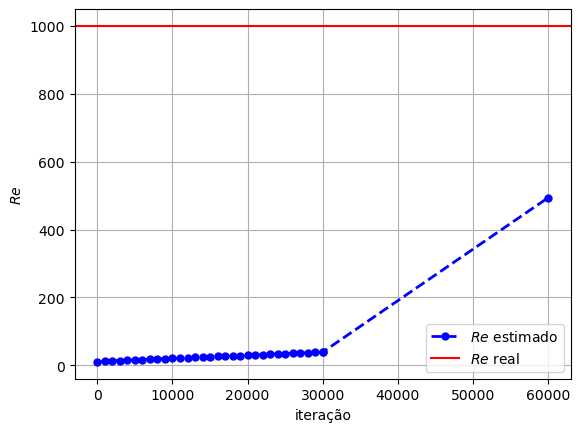

In [33]:
plot_parameter_approximation(f"./parameters/reynolds-{Re}.dat", Re, f"reynolds_nonoise-{Re}")

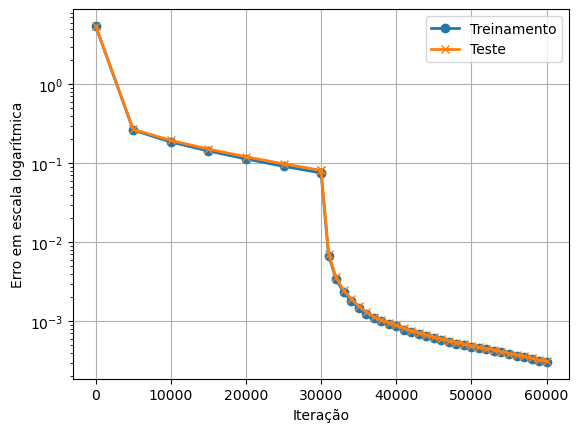

In [34]:
plot_and_save_losses(losshistory, f"reynolds_nonoise_loss-{Re}")

# Experimento com ruído
---
Vamos repetir o experimento acima, mas adicionando ruído gaussiano aos dados e às condições de fronteira.

In [16]:
noise_std = 0.2

In [17]:
def noisy_u_sol(x):
    u = u_sol(x)
    return u + np.random.normal(scale=noise_std, size=u.shape)

def noisy_v_sol(x):
    v = v_sol(x)
    return v + np.random.normal(scale=noise_std, size=v.shape)

def noisy_p_sol(x):
    p = p_sol(x)
    return p + np.random.normal(scale=noise_std, size=p.shape)

In [18]:
noisy_u_bc = dde.icbc.DirichletBC(
    spatial_domain, noisy_u_sol, lambda _, on_boundary: on_boundary, component=0
)

noisy_v_bc = dde.icbc.DirichletBC(
    spatial_domain, noisy_v_sol, lambda _, on_boundary: on_boundary, component=1
)

noisy_right_p_bc = dde.icbc.DirichletBC(
    spatial_domain, noisy_p_sol, boundary_outflow, component=2
)

noisy_data_u = noisy_u_sol(data_cp)
noisy_data_v = noisy_v_sol(data_cp)
noisy_data_p = noisy_p_sol(data_cp)

noisy_data_u_bc = dde.icbc.PointSetBC(data_cp, noisy_data_u, component=0)
noisy_data_v_bc = dde.icbc.PointSetBC(data_cp, noisy_data_v, component=1)
noisy_data_p_bc = dde.icbc.PointSetBC(data_cp, noisy_data_p, component=2)

In [19]:
noisy_data = dde.data.PDE(
    spatial_domain,
    pde,
    [
        noisy_u_bc, noisy_v_bc, noisy_right_p_bc,
        noisy_data_u_bc, noisy_data_v_bc, noisy_data_p_bc
    ],
    num_domain=num_domain,
    num_boundary=num_boundary,
    num_test=num_test,
    anchors=data_cp
)

In [20]:
noisy_model = dde.Model(noisy_data, net)

In [21]:
ex_Re = dde.Variable(Re_guess)

noisy_ex_variable_cb = dde.callbacks.VariableValue(
    [ex_Re], 
    period=1000, 
    filename=f"./parameters/noisy_reynolds-{Re}.dat"
)

noisy_model.compile("adam", lr=1e-3, external_trainable_variables=[ex_Re])

noisy_losshistory, noisy_train_state = noisy_model.train(
    iterations=30000, 
    display_every=5000,
    callbacks=[noisy_ex_variable_cb])

noisy_model.compile("L-BFGS", external_trainable_variables=[ex_Re])
noisy_losshistory, noisy_train_state = noisy_model.train(
    display_every=5000, 
    callbacks=[noisy_ex_variable_cb])

Compiling model...
'compile' took 0.000550 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [6.86e+00, 1.45e-03, 1.17e-04, 3.93e-02, 3.87e-02, 3.87e-02, 3.84e-02, 4.18e-02, 3.93e-02]    [6.91e+00, 1.40e-03, 9.87e-05, 3.93e-02, 3.87e-02, 3.87e-02, 3.84e-02, 4.18e-02, 3.93e-02]    []  
5000      [5.49e-02, 4.37e-03, 9.59e-03, 9.90e-02, 4.61e-02, 4.77e-02, 1.88e-01, 4.90e-02, 6.58e-02]    [6.14e-02, 2.63e-03, 9.23e-03, 9.90e-02, 4.61e-02, 4.77e-02, 1.88e-01, 4.90e-02, 6.58e-02]    []  
10000     [2.45e-02, 3.81e-02, 6.84e-02, 4.83e-01, 4.45e-02, 4.02e-02, 5.25e-01, 4.49e-02, 4.40e-02]    [1.27e-02, 2.95e-02, 4.78e-02, 4.83e-01, 4.45e-02, 4.02e-02, 5.25e-01, 4.49e-02, 4.40e-02]    []  
15000     [7.19e-02, 5.22e-03, 7.09e-03, 8.52e-02, 4.19e-02, 4.32e-02, 1.32e-01, 4.53e-02, 6.06e-02]    [7.41e-02, 4

In [22]:
dde.saveplot(
    noisy_losshistory, 
    noisy_train_state, 
    issave=True, 
    isplot=False, 
    output_dir="./losses", 
    loss_fname=f"Re{Re}-noisy-loss",
    train_fname=f"Re{Re}-noisy-train",
    test_fname=f"Re{Re}-noisy-test")

noisy_model.save(f"./models/Re{Re}-noisy")

Saving loss history to ./losses/Re1000-noisy-loss ...
Saving training data to ./losses/Re1000-noisy-train ...
Saving test data to ./losses/Re1000-noisy-test ...


'./models/Re1000-noisy-35286.pdparams'

In [23]:
ex_Re.cpu().numpy()

array(150.63179, dtype=float32)

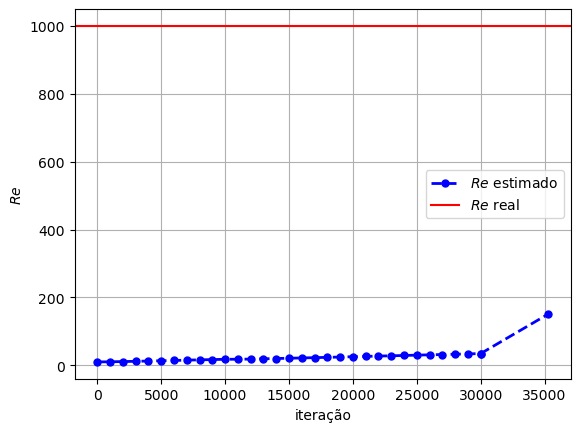

In [24]:
plot_parameter_approximation(f"./parameters/noisy_reynolds-{Re}.dat", Re, f"noisy_reynolds-{Re}")

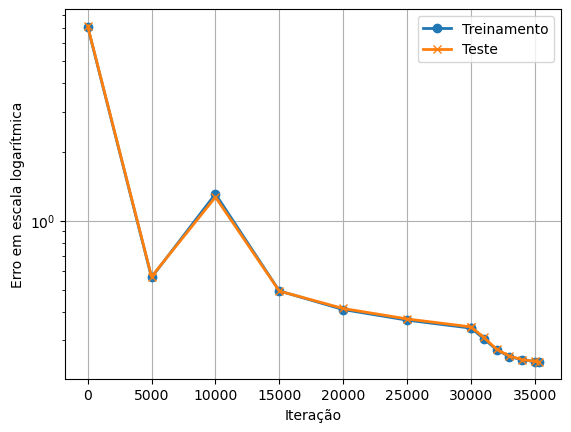

In [25]:
plot_and_save_losses(noisy_losshistory, f"noisy_reynolds_loss-{Re}")

## Comparando resultados

### Visualizando superfícies

In [26]:
nop = 100

X = np.linspace(-0.5, 1, nop)
Y = np.linspace(-0.5, 1.5, nop)

X, Y = np.meshgrid(X, Y)
XY = np.vstack((X.flatten(), Y.flatten())).T

predicted_values = noisy_model.predict(XY)

u_predicted = predicted_values[:,0].reshape((nop, nop))
u_real = u_sol(XY).reshape((nop, nop))
u_noisy = noisy_u_sol(XY).reshape((nop, nop))

v_predicted = predicted_values[:,1].reshape((nop, nop))
v_real = v_sol(XY).reshape((nop, nop))
v_noisy = noisy_v_sol(XY).reshape((nop, nop))

p_predicted = predicted_values[:,2].reshape((nop, nop))
p_real = p_sol(XY).reshape((nop, nop))
p_noisy = noisy_p_sol(XY).reshape((nop, nop))

In [27]:
def plot_3d_projection(surface, title):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.plot_surface(Y, X, surface, vmin=surface.min() * 2, cmap="viridis")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.savefig(f"./images/{title}-{Re}.png")
    plt.show()

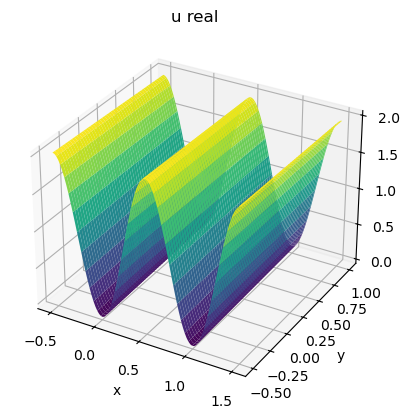

In [28]:
plot_3d_projection(u_real, "u real")

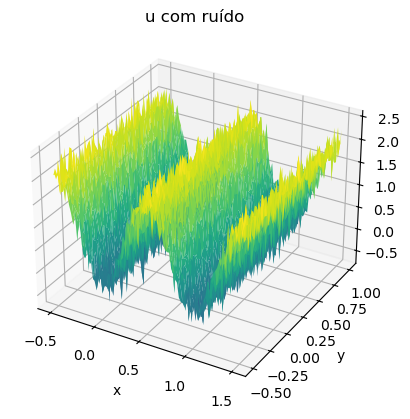

In [29]:
plot_3d_projection(u_noisy, "u com ruído")

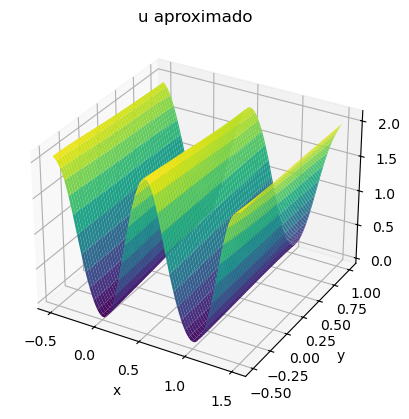

In [30]:
plot_3d_projection(u_predicted, "u aproximado")

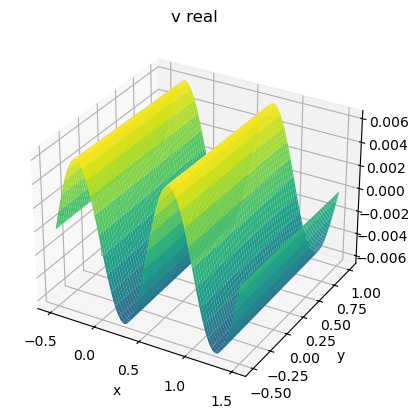

In [31]:
plot_3d_projection(v_real, "v real")

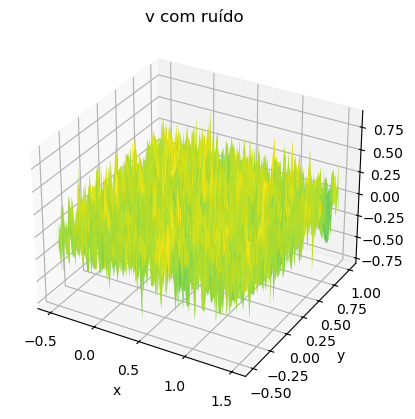

In [32]:
plot_3d_projection(v_noisy, "v com ruído")

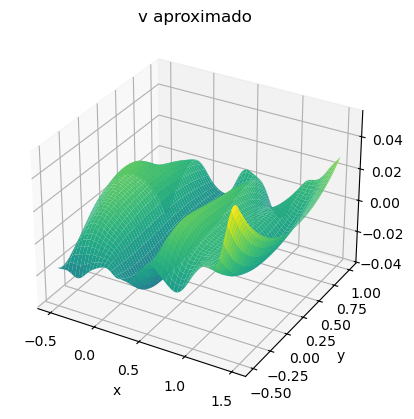

In [33]:
plot_3d_projection(v_predicted, "v aproximado")

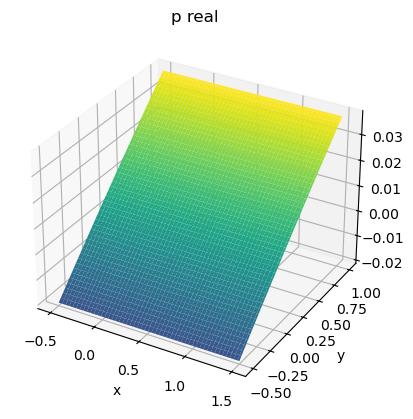

In [34]:
plot_3d_projection(p_real, "p real")

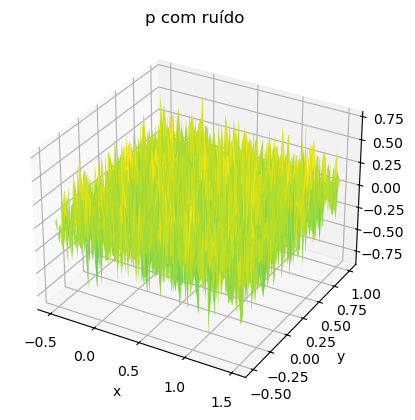

In [35]:
plot_3d_projection(p_noisy, "p com ruído")

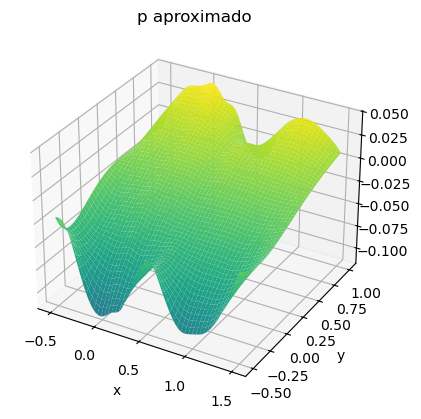

In [36]:
plot_3d_projection(p_predicted, "p aproximado")

### MSE

In [37]:
dde.metrics.mean_squared_error(u_real, u_predicted)

0.0013066926717253127

In [38]:
dde.metrics.mean_squared_error(v_real, v_predicted)

0.00011534591655141318

In [39]:
dde.metrics.mean_squared_error(p_real, p_predicted)

0.0012548539055586031

### MAPE

In [40]:
dde.metrics.mean_absolute_percentage_error(u_real, u_predicted)

np.float64(47.16942036072741)

In [41]:
dde.metrics.mean_absolute_percentage_error(v_real, v_predicted)

np.float64(264110.0572641467)

In [42]:
dde.metrics.mean_absolute_percentage_error(p_real, p_predicted)

np.float64(320159.21400133736)

### Acurácia

In [43]:
dde.metrics.accuracy(u_real, u_predicted)

np.float64(0.53)

In [44]:
dde.metrics.accuracy(v_real, v_predicted)

np.float64(0.1)

In [45]:
dde.metrics.accuracy(p_real, p_predicted)

np.float64(0.7)

### L2

In [46]:
dde.metrics.l2_relative_error(u_real, u_predicted)

np.float64(0.029366163706676274)

In [47]:
dde.metrics.l2_relative_error(v_real, v_predicted)

np.float64(2.452971391730879)

In [48]:
dde.metrics.l2_relative_error(p_real, p_predicted)

np.float64(1.8251162377881822)

### L-Infinity

In [49]:
np.max(np.abs(u_real - u_predicted))

np.float64(0.11155261177535392)

In [50]:
np.max(np.abs(v_real - v_predicted))

np.float64(0.05642592830508212)

In [51]:
np.max(np.abs(p_real - p_predicted))

np.float64(0.09392265896833407)